In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
from geopy.distance import geodesic
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics

### Datasets

In [160]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [161]:
def getPedestrian():
    pedestrian = pd.read_csv('../res/datasets/pedestrian/Pedestrian_Network_Data.csv', sep = ',')
    cols = ['OBJECTID', '_id', 'CROSSWALK_TYPE', 'SIDEWALK_CODE', 'CROSSWALK', 'PX_TYPE', 'PX']
    return pedestrian.drop(cols, axis=1)

In [162]:
coordinates = tdcsbSchools.drop(['_id', 'OBJECTID', 'TCDSB_CODE', 'SCH_NAME','ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE', 'TCDSB_LEVEL', 'STATUS'], axis = 1)

In [163]:
coordinates = coordinates['geometry'].astype('str')
coordinates = coordinates.apply(lambda x: ast.literal_eval(x))
coordinates = coordinates.apply(pd.Series)

In [164]:
#these are not data frames but instead series 
#be careful when working with them

Latitude = coordinates['coordinates'].apply(lambda x: x[1])
Longitude = coordinates['coordinates'].apply(lambda x: x[0])

### Parameters

In [251]:
STD_DEV = 0.6
PT_DENSITY = 50

### Scoring Functions

In [245]:
def getDistance(origin, stationCor):
    return abs(geodesic(origin, stationCor).meters/1000)

In [246]:
def score(latStation, longStation, latOrigin, longOrigin, stdDev):
    
    stationCor = (latStation, longStation)
    
    totalScore = 0
    count = 0
    
    for Lat, Long in zip(latOrigin, longOrigin):
        origin = (Lat, Long)
        r = getDistance(origin, stationCor)
        # this score function simply uses the traditional gaussian distribution formula,
        # except it extracts all the common parts to be multiplied last for efficiency.
        score =  math.exp(-0.5*((r**2) / (stdDev**2)))
        totalScore += score
            
    #adjustFactor = 210 * 0.9974
    #totalScore = (totalScorePre/adjustFactor)*100
    
    # Multiply common part in gaussian distribution formula
    totalScore *= (1/(stdDev * math.sqrt(2 * math.pi)))
    
    return totalScore

In [247]:
def generateGridScores(upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    scores = pd.DataFrame(columns = ['lat', 'long', 'score'])
    latStep = round((upperLatBound-bottomLatBound)/PT_DENSITY, 4)
    longStep = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)

    for lat in np.arange(bottomLatBound, upperLatBound, latStep):
        for long in np.arange(leftLongBound, rightLongBound, longStep):
            pointScore = score(lat, long, Latitude, Longitude, STD_DEV);
            pointScore = pointScore if pointScore > 0.1 else 0.0;
            pointScoreDict = {'lat' : [lat], 'long' : [long], 'score' : [pointScore]};
            pointScoreDf = pd.DataFrame(data=pointScoreDict)
            scores = pd.concat([scores, pointScoreDf], ignore_index = True)

            # print(score(lat, long, 0.4, Latitude, Longitude))
            # plot like this: lat - bottomLatBound,  long - leftLongBound
    return scores

### Regression

In [248]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)
    
    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()
    
    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [249]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    #x = scores['lat'].unique()
    x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

### Filtering and Processing

In [171]:
def trimOutOfBounds(points, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    df = pd.DataFrame({'lat': points[0], 'long': points[1]})
    df = df.loc[(df['lat'] >= bottomLatBound) & (df['lat'] <= upperLatBound) & (df['long'] >= leftLongBound) & (df['long'] <= rightLongBound)]
    return (df['lat'].values, df['long'].values)

In [172]:
def snapLongToGrid(points, leftLongBound, rightLongBound):
    step = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)
    pointsDf = pd.DataFrame({'lat': points[0], 'long': points[1]})
    for index, row in pointsDf.iterrows():
        pointsDf.at[index, 'long'] = pointsDf.at[index, 'long'] - ((pointsDf.at[index, 'long'] - leftLongBound) % step)
    return (pointsDf['lat'].values, pointsDf['long'].values)

### Plotting Functions

In [173]:
def plotScores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.scatter(scores["lat"], scores["long"], scores["score"])
    return ax

In [174]:
def plotScoresWithLine(scores, line):
    ax = plotScores(scores)
    ax.plot([line[0], line[1]], [line[2], line[3]], [0, 0], color='red', linewidth=3)
    return ax

In [175]:
def plotScoresWithCurve(scores, curve):
    ax = plotScores(scores)
    ax.scatter(curve[0], curve[1], 0)
    return ax

In [176]:
def plotHeatmap(scores, line):
    y_begin = line[2]
    y_end = line[3]
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    y_begin_hm = int((y_begin - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    y_end_hm = int((y_end - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    ax.plot([0, PT_DENSITY], [y_begin_hm, y_end_hm], linewidth=3, color='r')
    return ax

In [177]:
def plotHeatmapPolynomial(scores, curves):
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    for curve in curves:
        x = curve[0]
        y = curve[1]
        x_hm = [int(a) for a in ((x - scores["lat"].iloc[0]) / (scores["lat"].iloc[-1] - scores["lat"].iloc[0]) * PT_DENSITY)]
        y_hm = [int(a) for a in ((y - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)]
        ax.scatter(x_hm, y_hm, linewidth=1)
    return ax

### Toronto (YYZ)

In [252]:
# let coords only have 4 decimal points precision in ALL functions
#YYZ_UpperLatBound = round(43.806535, 4)
#YYZ_BottomLatBound = round(43.567208, 4)
#YYZ_LeftLongBound = round(-79.597003, 4)
#YYZ_RightLongBound = round(-79.322181, 4)

YYZ_UpperLatBound = round(Latitude.max(), 4)
YYZ_BottomLatBound = round(Latitude.min(), 4)
YYZ_LeftLongBound = round(Longitude.min(), 4)
YYZ_RightLongBound = round(Longitude.max(), 4)

YYZ_Scores = generateGridScores(YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)

In [253]:
[*YYZ_Line_1, YYZ_Line_1_intercept, YYZ_Line_1_coefficients] = polynomialRegression(YYZ_Scores, 3, YYZ_UpperLatBound, YYZ_BottomLatBound)
YYZ_Line_1 = trimOutOfBounds(YYZ_Line_1, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
YYZ_Line_1 = snapLongToGrid(YYZ_Line_1, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

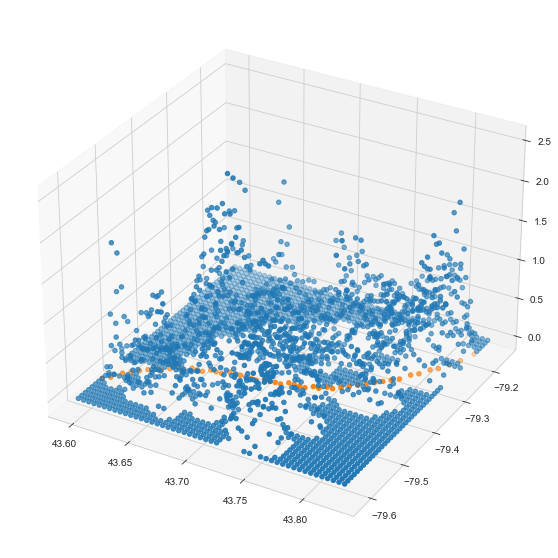

In [254]:
plotScoresWithCurve(YYZ_Scores, YYZ_Line_1)

<AxesSubplot:xlabel='lat', ylabel='long'>

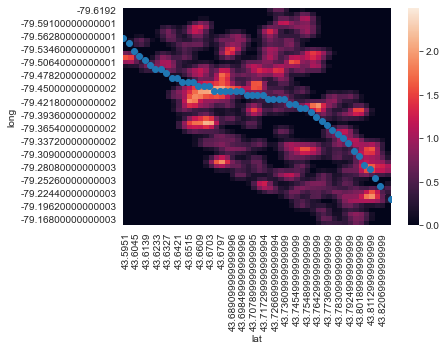

In [255]:
plotHeatmapPolynomial(YYZ_Scores, [YYZ_Line_1])

### Clustering Test

In [256]:
NUM_CLUSTERS = 5

In [257]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
YYZ_C_Scores = YYZ_Scores.copy()
YYZ_C_Scores = YYZ_C_Scores.loc[YYZ_C_Scores['score'] > 0.5]

In [258]:
#for index, row in YYZ_C_Scores.iterrows():
#    YYZ_C_Scores.at[index, 'score'] = (YYZ_C_Scores.at[index, 'score']*2)**2

In [259]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(YYZ_C_Scores[["lat", "long"]], 0, YYZ_C_Scores["score"])

In [260]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(YYZ_C_Scores[["lat", "long"]])
    distortions.append(kmeanModel.inertia_)

C:\Users\trieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


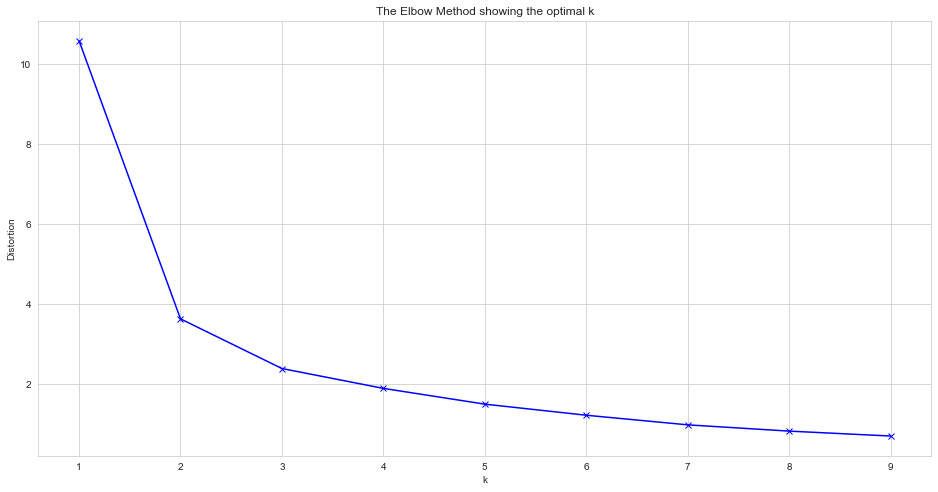

In [261]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

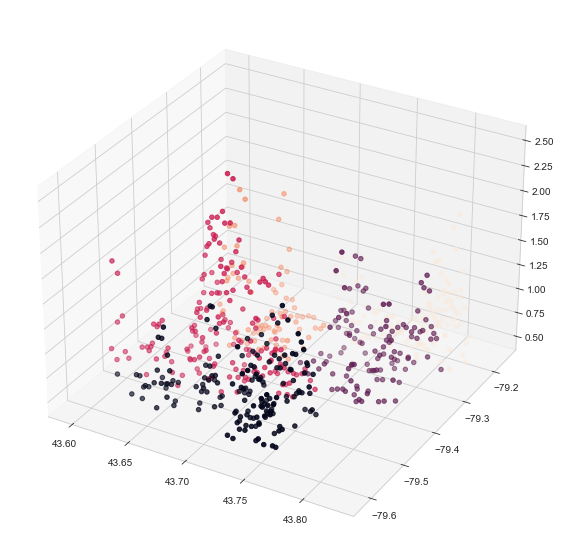

In [262]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], YYZ_C_Scores["score"], c=kmeans.labels_.astype(float))

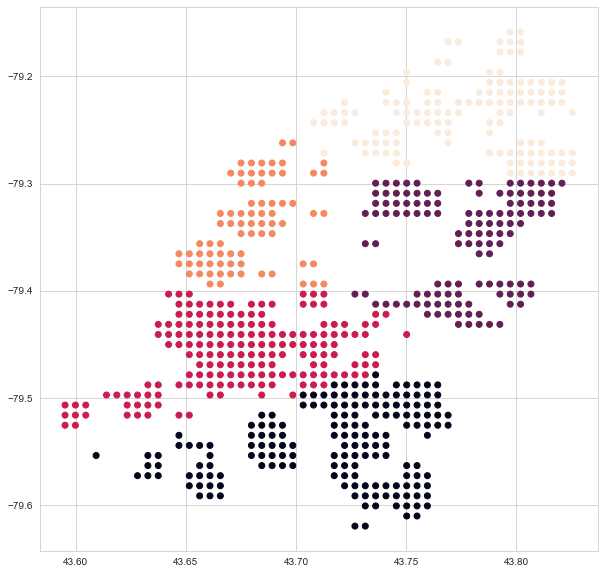

In [263]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], c=kmeans.labels_.astype(float))

In [264]:
YYZ_C_Scores['cluster'] = kmeans.labels_.tolist()

In [265]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, 5, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right)
    return (line, line_intercept, line_coefficients)

In [266]:
YYZ_Cx_Scores = []
for i in range(NUM_CLUSTERS):
    YYZ_Cx_Scores.append(YYZ_C_Scores.loc[YYZ_C_Scores['cluster'] == i])

In [267]:
YYZ_Cx_Line = []
for i in range(NUM_CLUSTERS):
    [line, _, _] = getLine(YYZ_Cx_Scores[i], YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
    YYZ_Cx_Line.append(line)

<AxesSubplot:xlabel='lat', ylabel='long'>

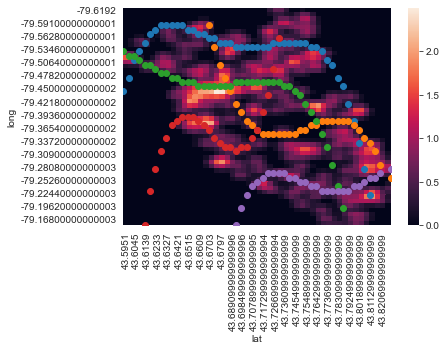

In [268]:
plotHeatmapPolynomial(YYZ_Scores, YYZ_Cx_Line)

In [269]:
YYZ_Cx_Line

[(array([43.5951, 43.5998, 43.6045, 43.6092, 43.6139, 43.6186, 43.6233,
         43.628 , 43.6327, 43.6374, 43.6421, 43.6468, 43.6515, 43.6562,
         43.6609, 43.6656, 43.6703, 43.675 , 43.6797, 43.6844, 43.6891,
         43.6938, 43.6985, 43.7032, 43.7079, 43.7126, 43.7173, 43.722 ,
         43.7267, 43.7314, 43.7361, 43.7408, 43.7455, 43.7502, 43.7549,
         43.7596, 43.7643, 43.769 , 43.7737, 43.7784, 43.7831, 43.7878,
         43.7925, 43.7972, 43.8019, 43.8066, 43.8113]),
  array([-79.4406, -79.4688, -79.5064, -79.5252, -79.544 , -79.5628,
         -79.5722, -79.5816, -79.5816, -79.5816, -79.5816, -79.5816,
         -79.5722, -79.5722, -79.5628, -79.5628, -79.5534, -79.5534,
         -79.544 , -79.544 , -79.544 , -79.5346, -79.5346, -79.5346,
         -79.5346, -79.5346, -79.5346, -79.5346, -79.544 , -79.544 ,
         -79.544 , -79.544 , -79.544 , -79.544 , -79.544 , -79.5346,
         -79.5346, -79.5252, -79.5064, -79.497 , -79.4688, -79.45  ,
         -79.4124, -79.3748, 

### Export Cells

In [270]:
with open('coords.txt', 'w') as f:
    f.write("----------LATS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for lat in line[0]:
            f.write(str(lat))
            f.write(',')
        f.write("],")
        f.write("\n")
    f.write("----------LONGS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for long in line[1]:
            f.write(str(long))
            f.write(',')
        f.write("],")
        f.write("\n")

In [197]:
with open('coordsSchools.txt', 'w') as f:
    for lat in Latitude:
        f.write(str(lat))
        f.write(',')
    f.write("\n")
    for long in Longitude:
        f.write(str(long))
        f.write(',')

###

### Toronto Test (Preliminary Work for Interchanges)